In [1]:
import sys
import re
import os
from datetime import datetime
from time import sleep
from IPython.display import display, clear_output, HTML
import logging

# set working dir
WORKING_DIR = re.sub('jdi-qasp-ml.*$','',os.path.normpath(os.getcwd())) + 'jdi-qasp-ml'
os.chdir(WORKING_DIR)

import utils
from utils import *
import torch
import pandas as pd
import numpy as np
import torch
from glob import glob
import selenium
from tqdm.auto import tqdm, trange

START_TS = datetime.now()
display(HTML(f'{START_TS} - Current working directory: <b>{WORKING_DIR}</b>'))

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
from scipy.sparse import csc_matrix, csr_matrix

import numba


2021-06-20 14:48:41,004 -INFO - config:config.py:16 - Module utils.config was loaded
2021-06-20 14:48:41,004 -INFO - common:common.py:618 - Module utils.common is loaded...
2021-06-20 14:48:41,007 -INFO - hidden:hidden.py:121 - hidden module is loaded
2021-06-20 14:48:41,304 -INFO - features_builder:features_builder.py:305 - feature_bilder module is loaded...
2021-06-20 14:48:41,309 -INFO - dataset_builder:dataset_builder.py:207 - dataset package is loaded...
2021-06-20 14:48:41,648 -INFO - dataset:dataset.py:277 - dataset module is loaded...


In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer



In [3]:
logger.setLevel(logging.WARNING)

In [4]:
datasets = [re.sub(r'^.*[/\\]+', '', re.sub(r'.parquet$', '', fn)) for fn in glob('dataset/df/*.parquet')]
datasets = [ d for d in datasets if not re.match(r'[0-9]+', d) and (d not in ['dummy', 'ac-avto161'])]
datasets

['angular',
 'bootstrap-1',
 'bootstrap-form',
 'bootstrap-forms',
 'bootstrap-reboot',
 'bootstrap',
 'cnews',
 'complex-table',
 'contact-form',
 'dates',
 'different-elements',
 'gitlab',
 'google-voice',
 'html-5',
 'login',
 'material-ui-Button Groups',
 'material-ui-Buttons',
 'material-ui-Checkbox',
 'material-ui-Floating Action Button',
 'material-ui-List',
 'material-ui-Progress',
 'material-ui-Radio',
 'material-ui-Select',
 'material-ui-Slider',
 'material-ui-Switch',
 'material-ui-Text Field',
 'material-ui-Textarea Autosize',
 'metals-and-colors',
 'mobile-and-html-5',
 'ms-office',
 'ozon',
 'performance',
 'phys-org',
 'react-ant',
 'search',
 'simple-table',
 'support',
 'table-with-pages',
 'user-table',
 'wildberries']

In [5]:
ds_list = []
with trange(len(datasets)) as bar:
    for ds in datasets:
        bar.set_postfix_str(f'Processing dataset: "{ds}"')
        df_file_path = f'dataset/df/{ds}.parquet'
        ann_file_path = f'dataset/annotations/{ds}.txt'
        
        if not os.path.exists(ann_file_path):
            print('skip:', (ann_file_path, df_file_path))
        else:
            df = pd.read_parquet(df_file_path)
            df = build_features(df)
            df = assign_labels(df=df, annotations_file_path=ann_file_path)
            ds_list.append(df)
            
        bar.update(1)

df = pd.concat(ds_list).copy()

  0%|          | 0/40 [00:00<?, ?it/s]

In [6]:
df.element_id.shape, df.element_id.nunique()

((47324,), 47324)

In [7]:
df[df.label_text != 'n/a'].shape[0]

4500

In [8]:
label_s = df.label_text.value_counts()
pd.DataFrame(label_s)

,label_text
n/a,42824
link,2359
button,1207
checkbox,245
textfield,229
radiobutton,122
selector,85
datetimeselector,34
table,32
slider,30


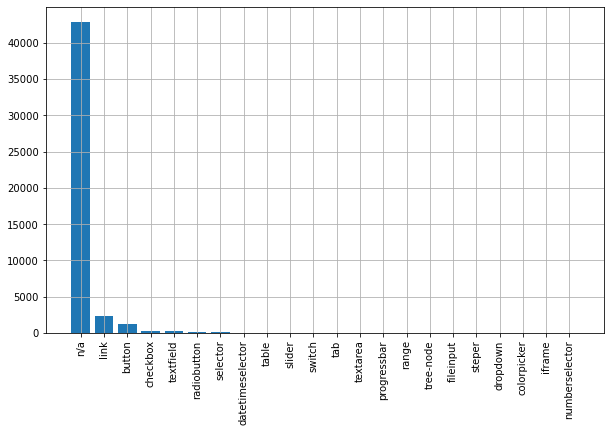

In [9]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.bar(label_s.index, label_s.values)
_ = plt.xticks(rotation='vertical')


In [10]:
label_s.iloc[1:].sum(), label_s.iloc[0]

(4500, 42824)

In [11]:
# plt.figure(figsize=(10,10))
# plt.pie(x=label_s.values, 
#         labels=label_s.index, 
#         labeldistance=1.1,
#         shadow=False,
#         explode = [0.1 for _ in label_s.index]
#        );

In [12]:
df.tag_name.value_counts()

DIV                          12660
SPAN                          9155
A                             3837
TD                            2750
LI                            1918
                             ...  
EXAMPLE-TEL-INPUT                1
SIDENAV-MODE-EXAMPLE             1
RADIO-OVERVIEW-EXAMPLE           1
DATEPICKER-EVENTS-EXAMPLE        1
MAT-NAV-LIST                     1
Name: tag_name, Length: 308, dtype: int64

# tag_name

In [13]:
tag_name_series = df[df.label_text != 'n/a'].tag_name.value_counts()
display(tag_name_series)
tag_name_set = set(tag_name_series.index)

A                    2263
DIV                   771
BUTTON                507
INPUT                 481
LABEL                  78
SPAN                   75
LI                     53
SELECT                 52
P                      44
MAT-RADIO-BUTTON       28
MAT-CHECKBOX           23
TABLE                  23
MAT-SELECT             22
TEXTAREA               22
SVG                    13
MAT-TREE-NODE           8
IMG                     8
IFRAME                  5
MAT-SLIDER              5
MAT-BUTTON-TOGGLE       5
MAT-SLIDE-TOGGLE        3
RECT                    2
PROGRESS                2
CIRCLE                  2
I                       1
MAT-TABLE               1
H5                      1
H2                      1
G                       1
Name: tag_name, dtype: int64

In [14]:
tag_name_ohe = OneHotEncoder(handle_unknown='ignore', categories=[list(tag_name_set)])
tag_name_ohe

OneHotEncoder(categories=[['MAT-TREE-NODE', 'INPUT', 'CIRCLE', 'DIV', 'TABLE',
                           'SELECT', 'MAT-CHECKBOX', 'MAT-SLIDE-TOGGLE', 'LI',
                           'BUTTON', 'MAT-TABLE', 'TEXTAREA', 'IMG', 'RECT',
                           'H2', 'MAT-RADIO-BUTTON', 'LABEL', 'P', 'IFRAME',
                           'SVG', 'MAT-SELECT', 'A', 'PROGRESS', 'MAT-SLIDER',
                           'G', 'MAT-BUTTON-TOGGLE', 'I', 'SPAN', 'H5']],
              handle_unknown='ignore')

In [15]:
np.expand_dims(df.tag_name.values, -1)

array([['DIV'],
       ['DIV'],
       ['PATH'],
       ...,
       ['DIV'],
       ['H4'],
       ['USE']], dtype=object)

In [16]:
tag_name_ohe.fit(np.expand_dims(df[df.label_text != 'n/a'].tag_name.values, -1))

OneHotEncoder(categories=[['MAT-TREE-NODE', 'INPUT', 'CIRCLE', 'DIV', 'TABLE',
                           'SELECT', 'MAT-CHECKBOX', 'MAT-SLIDE-TOGGLE', 'LI',
                           'BUTTON', 'MAT-TABLE', 'TEXTAREA', 'IMG', 'RECT',
                           'H2', 'MAT-RADIO-BUTTON', 'LABEL', 'P', 'IFRAME',
                           'SVG', 'MAT-SELECT', 'A', 'PROGRESS', 'MAT-SLIDER',
                           'G', 'MAT-BUTTON-TOGGLE', 'I', 'SPAN', 'H5']],
              handle_unknown='ignore')

In [17]:
tag_name_sm = tag_name_ohe.transform(np.expand_dims(df.tag_name.values, -1))
tag_name_sm

<47324x29 sparse matrix of type '<class 'numpy.float64'>'
	with 33845 stored elements in Compressed Sparse Row format>

In [18]:
logger.setLevel(logging.DEBUG)
tag_name_sm = build_tag_name_feature(df)
tag_name_sm

2021-06-20 14:49:14,543 -INFO - features_builder:features_builder.py:228 - used column: tag_name
2021-06-20 14:49:14,544 -INFO - features_builder:features_builder.py:231 - loading model/ohe_tag_name.pkl


<47324x28 sparse matrix of type '<class 'numpy.float64'>'
	with 33557 stored elements in Compressed Sparse Row format>

# attributes.role

In [19]:
attr_role_series = df[df.label_text != 'n/a'].attributes.apply(lambda x: None if x is None else x.get('role')).fillna('')
attr_role_series.value_counts()

               3780
button          616
tab              34
listbox          22
grid             12
switch            9
combobox          8
group             8
slider            5
progressbar       3
option            3
Name: attributes, dtype: int64

In [20]:
attr_role_ohe = OneHotEncoder(handle_unknown='ignore').fit(np.expand_dims(attr_role_series.values, -1))
attr_role_ohe

OneHotEncoder(handle_unknown='ignore')

In [21]:
attr_role_sm = attr_role_ohe.transform(
    np.expand_dims(
        df.attributes.apply(lambda x: None if x is None else x.get('role')).fillna(''),
        -1
    )
)
attr_role_sm

<47324x11 sparse matrix of type '<class 'numpy.float64'>'
	with 46135 stored elements in Compressed Sparse Row format>

In [22]:
logger.setLevel(logging.DEBUG)
role_sm = build_role_feature(df)
role_sm

2021-06-20 14:49:14,653 -INFO - features_builder:features_builder.py:251 - used column: attributes
2021-06-20 14:49:14,654 -INFO - features_builder:features_builder.py:254 - loading model/ohe_role.pkl


<47324x11 sparse matrix of type '<class 'numpy.float64'>'
	with 46135 stored elements in Compressed Sparse Row format>

# attributes.type

In [23]:
attr_type_series = df[df.label_text != 'n/a'].attributes.apply(lambda x: None if x is None else x.get('type')).fillna('')
attr_type_series.value_counts()

                               3703
button                          339
checkbox                        151
text                             95
submit                           41
number                           34
radio                            31
range                            22
search                           15
password                         13
email                            13
file                              9
addToCartButtonWithQuantity       6
reset                             5
color                             5
datetime-local                    3
month                             3
time                              3
week                              3
date                              3
tel                               2
url                               1
Name: attributes, dtype: int64

In [24]:
attr_type_ohe = OneHotEncoder(handle_unknown='ignore').fit(np.expand_dims(attr_type_series.values, -1))
attr_type_ohe

OneHotEncoder(handle_unknown='ignore')

In [25]:
attr_type_sm = attr_type_ohe.transform(
    np.expand_dims(
        df.attributes.apply(lambda x: None if x is None else x.get('type')).fillna(''),
        -1
    )
)
attr_type_sm

<47324x22 sparse matrix of type '<class 'numpy.float64'>'
	with 47069 stored elements in Compressed Sparse Row format>

In [26]:
logger.setLevel(logging.DEBUG)
type_sm = build_type_feature(df)
type_sm

2021-06-20 14:49:14,796 -INFO - features_builder:features_builder.py:279 - used column: attributes
2021-06-20 14:49:14,797 -INFO - features_builder:features_builder.py:282 - loading model/ohe_type.pkl


<47324x22 sparse matrix of type '<class 'numpy.float64'>'
	with 47069 stored elements in Compressed Sparse Row format>

# attributes.ui

In [27]:
attr_ui_series = df[df.label_text != 'n/a'].attributes.apply(lambda x: None if x is None else x.get('ui')).fillna('')
attr_ui_series.value_counts()

               4444
label            38
furniture         5
table             3
dropdown          2
d-table           2
github-link       2
link              1
products          1
products-2        1
textarea          1
Name: attributes, dtype: int64

In [28]:
attr_ui_ohe = OneHotEncoder(handle_unknown='ignore').fit(np.expand_dims(attr_ui_series.values, -1))
attr_ui_ohe

OneHotEncoder(handle_unknown='ignore')

In [29]:
attr_ui_sm = attr_ui_ohe.transform(
    np.expand_dims(
        df.attributes.apply(lambda x: None if x is None else x.get('ui')).fillna(''),
        -1
    )
)
attr_ui_sm

<47324x11 sparse matrix of type '<class 'numpy.float64'>'
	with 47315 stored elements in Compressed Sparse Row format>

- I find that column UI is useless

# attributes.class

In [30]:
attr_class_series = df[df.label_text != 'n/a'].attributes.apply(lambda x: None if x is None else x.get('class')).fillna('')
attr_class_series.value_counts()

                                                                                                                                        1368
MuiButtonBase-root MuiListItem-root MuiListItem-gutters MuiListItem-button                                                               592
news-link                                                                                                                                165
_1-6r                                                                                                                                    124
_1V0q                                                                                                                                    103
                                                                                                                                        ... 
mat-input-element mat-form-field-autofill-control ng-tns-c95-83 cdk-text-field-autofill-monitored                                          1
mat-focus-ind

In [31]:
class_cv = CountVectorizer()

In [32]:
class_cv.fit(attr_class_series.values)

CountVectorizer()

In [33]:
vocabulary = sorted([v for v in class_cv.vocabulary_.keys() if re.match(r'^[a-z]+$',v ) and len(v) > 2])
print(len(vocabulary))
print(vocabulary)

363
['above', 'accent', 'account', 'action', 'active', 'add', 'alert', 'align', 'all', 'anchorjs', 'ani', 'ant', 'appearance', 'arrow', 'autocomplete', 'autofill', 'autosize', 'badge', 'bannerclose', 'bar', 'base', 'before', 'benefits', 'black', 'block', 'blue', 'body', 'bold', 'border', 'bottom', 'brand', 'breaking', 'btn', 'btnprimary', 'buffer', 'button', 'buttonlink', 'buttonnew', 'buttontext', 'buy', 'carbon', 'card', 'carousel', 'cascader', 'cat', 'cdk', 'center', 'change', 'char', 'check', 'checkbox', 'checked', 'checkmark', 'children', 'chip', 'circle', 'circledisableshrink', 'circleindeterminate', 'click', 'clipboard', 'close', 'cnb', 'cnm', 'collapsed', 'colorprimary', 'colorsecondary', 'column', 'company', 'comparisons', 'contained', 'containedprimary', 'containedsecondary', 'containedsizelarge', 'containedsizesmall', 'container', 'content', 'control', 'corner', 'cta', 'current', 'custom', 'danger', 'dark', 'dashed', 'dashedcolorprimary', 'datatable', 'default', 'delete', 'd

In [34]:
attr_class_cv = CountVectorizer(vocabulary=vocabulary) #.fit(attr_class_series.values)
attr_class_cv

CountVectorizer(vocabulary=['above', 'accent', 'account', 'action', 'active',
                            'add', 'alert', 'align', 'all', 'anchorjs', 'ani',
                            'ant', 'appearance', 'arrow', 'autocomplete',
                            'autofill', 'autosize', 'badge', 'bannerclose',
                            'bar', 'base', 'before', 'benefits', 'black',
                            'block', 'blue', 'body', 'bold', 'border', 'bottom', ...])

In [35]:
attr_class_sm = attr_class_cv.transform(attr_class_series.values)
attr_class_mx = attr_class_sm.todense()
attr_class_sm

<4500x363 sparse matrix of type '<class 'numpy.int64'>'
	with 10678 stored elements in Compressed Sparse Row format>

In [36]:
attr_class_mx[10]

matrix([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 4, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [37]:
attr_class_tfidf = TfidfVectorizer(vocabulary=vocabulary).fit(attr_class_series.values)

In [38]:
attr_class_sm = attr_class_tfidf.transform(attr_class_series.values)
attr_class_mx = attr_class_sm.todense()
attr_class_sm, type(attr_class_sm)

(<4500x363 sparse matrix of type '<class 'numpy.float64'>'
 	with 10678 stored elements in Compressed Sparse Row format>,
 scipy.sparse.csr.csr_matrix)

In [39]:
logger.setLevel(logging.DEBUG)
attr_class_sm = build_class_feature(df)
attr_class_sm

2021-06-20 14:49:15,143 -INFO - features_builder:features_builder.py:188 - used column: attributes
2021-06-20 14:49:15,144 -INFO - features_builder:features_builder.py:191 - TfIdfVectorizer for class attribute exists. Loaging...


<47324x353 sparse matrix of type '<class 'numpy.float64'>'
	with 60648 stored elements in Compressed Sparse Row format>

# Explore attributes

In [40]:
from collections import Counter

stats_na = Counter()
stats_ctl = Counter()
stats_all = Counter()

print('Number of labels:', df[df.label_text != 'n/a'].shape[0])

# Will use Only attributes from labeled classes 

for _, r in tqdm(df[['attributes', 'label_text', 'displayed']].iterrows()):
    if r.attributes is not None:
        lst = [k for k in r.attributes.keys() if (r.attributes.get(k) is not None) and (str(r.attributes.get(k)).strip() != "")]
        if r.label_text == 'n/a':
            stats_na.update(lst)
        else:
            stats_ctl.update(lst)
        stats_all.update(lst)
attributes_na_df = pd.DataFrame({'keys': stats_na.keys(), 'counts': stats_na.values()}).sort_values(by='counts', ascending=False)

attributes_ctl_df = pd.DataFrame({'keys': stats_ctl.keys(), 'counts': stats_ctl.values()}).sort_values(by='counts', ascending=False)
attributes_all_df = pd.DataFrame({'keys': stats_all.keys(), 'counts': stats_all.values()}).sort_values(by='counts', ascending=False)


Number of labels: 4500


0it [00:00, ?it/s]

In [41]:
attributes_all_df['p_all']=attributes_all_df.counts/df.shape[0]
attributes_all_df

,keys,counts,p_all
0,class,30612,0.646860
19,href,5076,0.107261
12,id,2628,0.055532
13,role,2258,0.047714
15,style,2207,0.046636
...,...,...,...
266,data-js-auto-suggest-position,1,0.000021
139,data-offset,1,0.000021
140,data-spy,1,0.000021
143,data-pause,1,0.000021


In [42]:
attr_stats_df = attributes_na_df.merge(attributes_ctl_df, on='keys', how='left')
attr_stats_df = attr_stats_df.merge(attributes_all_df[['keys', 'p_all']], on = 'keys', how='left')

counts_x_sum, counts_y_sum = attr_stats_df.agg({ 'counts_x': 'sum', 'counts_y': 'sum'}).values
attr_stats_df['p_x'] = attr_stats_df.counts_x / counts_x_sum
attr_stats_df['p_y'] = attr_stats_df.counts_y / counts_y_sum


attr_stats_df['importance'] = attr_stats_df['p_y'] / attr_stats_df['p_x']

attr_stats_df[(attr_stats_df.p_x < attr_stats_df.p_y) & (attr_stats_df.counts_y > 30)].sort_values(by='p_y', ascending=False).head(50)



,keys,counts_x,counts_y,p_all,p_x,p_y,importance
1,href,2922,2154.0,0.107261,0.052657,0.177693,3.374534
10,tabindex,700,952.0,0.034908,0.012615,0.078535,6.225686
9,type,766,797.0,0.033028,0.013804,0.065748,4.762970
5,role,1538,720.0,0.047714,0.027716,0.059396,2.143011
23,aria-disabled,323,682.0,0.021237,0.005821,0.056261,9.665629
4,id,2024,604.0,0.055532,0.036474,0.049827,1.366075
29,target,282,596.0,0.018553,0.005082,0.049167,9.674876
34,aria-label,191,227.0,0.008833,0.003442,0.018726,5.440524
84,placeholder,24,141.0,0.003487,0.000433,0.011632,26.894046
115,aria-invalid,14,130.0,0.003043,0.000252,0.010724,42.507307


In [43]:
_keys = set([
    'aria-invalid', 
    'aria-haspopup', 
    'aria-expanded',      
    'aria-required',
    'aria-disabled',
    'aria-selected',
    'aria-describedby',
    'aria-controls',
    'aria-invalid',
    'placeholder',
    'value',
    'for',
    'onclick',
    'target',
    'role',
    'type',
    'id',
    'name',
    'href',
    'min',
    'max'
])

report = []
with trange(df.shape[0]) as bar:
    for _, r in df.iterrows():
        attr = r.attributes
        if type(attr) is dict:
            d = {}
            d['label'] = 1 if r.label_text != 'n/a' else 0
            for k in _keys:
                v = attr.get(k)
                if v is not None and v.strip() != "":
                    d[k]=1
                else:
                    d[k]=0
        else:
            d = {k:0 for k in _keys}
                
        report.append(d)
        bar.update(1)

report_df = pd.DataFrame(report)

  0%|          | 0/47324 [00:00<?, ?it/s]

In [44]:
report_df.sum(axis=1).value_counts()

0.0    35526
1.0     6239
2.0     3469
3.0     1573
4.0      299
5.0      103
6.0      100
7.0        9
9.0        4
8.0        2
dtype: int64

In [45]:
df.attributes.apply(lambda x: x.get('target') if x is not None else None).value_counts()

_blank    762
_self     115
_top        1
Name: attributes, dtype: int64

In [46]:
df.columns

Index(['attributes', 'displayed', 'element_id', 'height', 'onmouseenter',
       'onmouseover', 'parent_id', 'style', 'tag_name', 'text', 'width', 'x',
       'y', 'is_hidden', 'upper_sibling', 'lower_sibling', 'siblings', 'idx',
       'label', 'annotation_line_no', 'iou', 'tag', 'label_text', 'dataset'],
      dtype='object')

In [47]:
report_df.corr()

,label,value,aria-selected,aria-describedby,id,aria-expanded,aria-required,max,aria-controls,target,...,role,placeholder,aria-haspopup,href,aria-invalid,aria-disabled,name,min,type,for
label,1.000000,0.052391,0.068072,0.084679,0.105975,0.069716,0.131264,0.083529,0.066686,0.271817,...,0.166268,0.152511,0.091411,0.384226,0.151579,0.291139,0.009703,0.082722,0.258425,0.009300
value,0.052391,1.000000,-0.003144,0.021683,0.188231,-0.004821,0.020831,0.205560,-0.004069,-0.013859,...,-0.018589,0.094630,-0.003651,-0.034939,0.040569,-0.010441,0.319486,0.187479,0.298941,-0.010645
aria-selected,0.068072,-0.003144,1.000000,-0.001054,0.110873,-0.001492,-0.001540,-0.001044,0.671718,-0.004289,...,0.139352,-0.001845,-0.001130,0.006719,-0.001723,0.131803,-0.003138,-0.001074,0.005619,-0.003294
aria-describedby,0.084679,0.021683,-0.001054,1.000000,0.071062,-0.001616,0.176307,-0.001132,-0.001364,-0.004647,...,0.039416,0.199754,-0.001224,-0.011716,0.202685,0.008046,0.009172,-0.001163,0.056797,-0.003569
id,0.105975,0.188231,0.110873,0.071062,1.000000,0.042545,0.203544,0.063606,0.102387,-0.028552,...,0.036191,0.162541,0.080497,-0.029186,0.224486,0.009082,0.172048,0.064118,0.259807,0.075985
aria-expanded,0.069716,-0.004821,-0.001492,-0.001616,0.042545,1.000000,0.051605,-0.001601,0.283740,-0.003294,...,0.086936,0.057273,0.230877,-0.002267,0.045599,0.008313,-0.000363,-0.001646,0.090280,-0.005051
aria-required,0.131264,0.020831,-0.001540,0.176307,0.203544,0.051605,1.000000,0.011179,-0.001992,-0.006786,...,0.053382,0.244637,0.271108,-0.017108,0.893376,0.070128,0.003656,0.048236,0.055720,-0.005212
max,0.083529,0.205560,-0.001044,-0.001132,0.063606,-0.001601,0.011179,1.000000,-0.001352,-0.004604,...,-0.004531,0.190947,0.016253,-0.011606,0.009621,-0.000550,-0.003368,0.936061,0.167038,-0.003536
aria-controls,0.066686,-0.004069,0.671718,-0.001364,0.102387,0.283740,-0.001992,-0.001352,1.000000,-0.005550,...,0.109024,0.006507,0.027526,0.001255,-0.002230,0.095876,0.006470,-0.001390,0.060015,-0.004263
target,0.271817,-0.013859,-0.004289,-0.004647,-0.028552,-0.003294,-0.006786,-0.004604,-0.005550,1.000000,...,-0.029307,-0.008133,-0.000651,0.396657,-0.007596,-0.003960,-0.013830,-0.004732,-0.025410,-0.014520


In [48]:
logger.setLevel(logging.DEBUG)
attributes_df = build_attributes_feature(df)
attributes_df

2021-06-20 14:49:53,552 -INFO - features_builder:features_builder.py:152 - used column: attributes


  0%|          | 0/47324 [00:00<?, ?it/s]

,aria-invalid,aria-haspopup,aria-expanded,aria-required,aria-disabled,aria-selected,aria-describedby,aria-controls,placeholder,value,for,onclick,target,id,name,min,max
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47319,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
47320,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
47321,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
47322,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [49]:
csr_matrix(attributes_df.values), attributes_df.values.sum()

(<47324x17 sparse matrix of type '<class 'numpy.int64'>'
 	with 6939 stored elements in Compressed Sparse Row format>,
 6939)

In [50]:
df.columns

Index(['attributes', 'displayed', 'element_id', 'height', 'onmouseenter',
       'onmouseover', 'parent_id', 'style', 'tag_name', 'text', 'width', 'x',
       'y', 'is_hidden', 'upper_sibling', 'lower_sibling', 'siblings', 'idx',
       'label', 'annotation_line_no', 'iou', 'tag', 'label_text', 'dataset'],
      dtype='object')

# Check for duplicates

In [51]:
assert df.element_id.nunique() == df.shape[0], "There are duplicates in the dataset"
display(HTML("<h1><b>The dataset is OK, there are no duplicates</b></h1>"))

<hr style="height: 5px">

# DatasetCollector

In [52]:
COLS = ['element_id', 'tag_name', 'attributes', 'displayed', 'is_hidden']
TARGET_PARENT_COLUMNS = ['parent_id', 'tag_name_parent', 'attributes_parent', 'displayed_parent', 'is_hidden_parent']
df_parent = df[COLS].copy()
df_parent.columns = TARGET_PARENT_COLUMNS
df.shape

TARGET_UP_SIBLING_COLUMNS = ['upper_sibling', 'tag_name_upsib', 'attributes_upsib', 'displayed_upsib', 'is_hidden_upsib']
upsib_df = df[COLS].copy()
upsib_df.columns = TARGET_UP_SIBLING_COLUMNS

TARGET_DN_SIBLING_COLUMNS = ['lower_sibling', 'tag_name_dnsib', 'attributes_dnsib', 'displayed_dnsib', 'is_hidden_dnsib']
dnsib_df = df[COLS].copy()
dnsib_df.columns = TARGET_DN_SIBLING_COLUMNS



In [53]:
train_df = df.merge(df_parent, on='parent_id', how='left')
train_df = train_df.merge(upsib_df, on='upper_sibling', how='left')
train_df = train_df.merge(dnsib_df, on='lower_sibling', how='left')


In [54]:
train_df.shape, train_df.columns

((47324, 36),
 Index(['attributes', 'displayed', 'element_id', 'height', 'onmouseenter',
        'onmouseover', 'parent_id', 'style', 'tag_name', 'text', 'width', 'x',
        'y', 'is_hidden', 'upper_sibling', 'lower_sibling', 'siblings', 'idx',
        'label', 'annotation_line_no', 'iou', 'tag', 'label_text', 'dataset',
        'tag_name_parent', 'attributes_parent', 'displayed_parent',
        'is_hidden_parent', 'tag_name_upsib', 'attributes_upsib',
        'displayed_upsib', 'is_hidden_upsib', 'tag_name_dnsib',
        'attributes_dnsib', 'displayed_dnsib', 'is_hidden_dnsib'],
       dtype='object'))

In [55]:
parent_attributes_sm = csr_matrix(build_attributes_feature(df = train_df, colname = 'attributes_parent').values)
parent_attributes_sm

2021-06-20 14:49:57,503 -INFO - features_builder:features_builder.py:152 - used column: attributes_parent


  0%|          | 0/47324 [00:00<?, ?it/s]

<47324x17 sparse matrix of type '<class 'numpy.int64'>'
	with 6424 stored elements in Compressed Sparse Row format>

In [56]:
upsib_attributes_sm = csr_matrix(build_attributes_feature(df = train_df, colname = 'attributes_upsib').values)
upsib_attributes_sm

2021-06-20 14:50:01,181 -INFO - features_builder:features_builder.py:152 - used column: attributes_upsib


  0%|          | 0/47324 [00:00<?, ?it/s]

<47324x17 sparse matrix of type '<class 'numpy.int64'>'
	with 3597 stored elements in Compressed Sparse Row format>

In [57]:
dnsib_attributes_sm = csr_matrix(build_attributes_feature(df = train_df, colname = 'attributes_dnsib').values)
dnsib_attributes_sm

2021-06-20 14:50:04,826 -INFO - features_builder:features_builder.py:152 - used column: attributes_dnsib


  0%|          | 0/47324 [00:00<?, ?it/s]

<47324x17 sparse matrix of type '<class 'numpy.int64'>'
	with 2849 stored elements in Compressed Sparse Row format>

<hr>

- # class

In [58]:
build_class_feature(train_df, colname='attributes')

2021-06-20 14:50:08,453 -INFO - features_builder:features_builder.py:188 - used column: attributes
2021-06-20 14:50:08,455 -INFO - features_builder:features_builder.py:191 - TfIdfVectorizer for class attribute exists. Loaging...


<47324x353 sparse matrix of type '<class 'numpy.float64'>'
	with 60648 stored elements in Compressed Sparse Row format>

In [59]:
build_class_feature(train_df, colname='attributes_parent')

2021-06-20 14:50:08,643 -INFO - features_builder:features_builder.py:188 - used column: attributes_parent
2021-06-20 14:50:08,644 -INFO - features_builder:features_builder.py:191 - TfIdfVectorizer for class attribute exists. Loaging...


<47324x353 sparse matrix of type '<class 'numpy.float64'>'
	with 69851 stored elements in Compressed Sparse Row format>

In [60]:
build_class_feature(train_df, colname='attributes_upsib')

2021-06-20 14:50:08,847 -INFO - features_builder:features_builder.py:188 - used column: attributes_upsib
2021-06-20 14:50:08,848 -INFO - features_builder:features_builder.py:191 - TfIdfVectorizer for class attribute exists. Loaging...


<47324x353 sparse matrix of type '<class 'numpy.float64'>'
	with 26515 stored elements in Compressed Sparse Row format>

In [61]:
build_class_feature(train_df, colname='attributes_dnsib')

2021-06-20 14:50:09,007 -INFO - features_builder:features_builder.py:188 - used column: attributes_dnsib
2021-06-20 14:50:09,008 -INFO - features_builder:features_builder.py:191 - TfIdfVectorizer for class attribute exists. Loaging...


<47324x353 sparse matrix of type '<class 'numpy.float64'>'
	with 25300 stored elements in Compressed Sparse Row format>

<hr>

- # tag_name

In [62]:
build_tag_name_feature(train_df, colname='tag_name')

2021-06-20 14:50:09,164 -INFO - features_builder:features_builder.py:228 - used column: tag_name
2021-06-20 14:50:09,165 -INFO - features_builder:features_builder.py:231 - loading model/ohe_tag_name.pkl


<47324x28 sparse matrix of type '<class 'numpy.float64'>'
	with 33557 stored elements in Compressed Sparse Row format>

In [63]:
build_tag_name_feature(train_df, colname='tag_name_parent')

2021-06-20 14:50:09,196 -INFO - features_builder:features_builder.py:228 - used column: tag_name_parent
2021-06-20 14:50:09,197 -INFO - features_builder:features_builder.py:231 - loading model/ohe_tag_name.pkl


<47324x28 sparse matrix of type '<class 'numpy.float64'>'
	with 29804 stored elements in Compressed Sparse Row format>

In [64]:
build_tag_name_feature(train_df, colname='tag_name_upsib')

2021-06-20 14:50:09,229 -INFO - features_builder:features_builder.py:228 - used column: tag_name_upsib
2021-06-20 14:50:09,230 -INFO - features_builder:features_builder.py:231 - loading model/ohe_tag_name.pkl


<47324x28 sparse matrix of type '<class 'numpy.float64'>'
	with 16603 stored elements in Compressed Sparse Row format>

In [65]:
build_tag_name_feature(train_df, colname='tag_name_dnsib')

2021-06-20 14:50:09,260 -INFO - features_builder:features_builder.py:228 - used column: tag_name_dnsib
2021-06-20 14:50:09,261 -INFO - features_builder:features_builder.py:231 - loading model/ohe_tag_name.pkl


<47324x28 sparse matrix of type '<class 'numpy.float64'>'
	with 17004 stored elements in Compressed Sparse Row format>

<hr>

- # type

In [66]:
build_type_feature(train_df, colname='attributes')

2021-06-20 14:50:09,291 -INFO - features_builder:features_builder.py:279 - used column: attributes
2021-06-20 14:50:09,292 -INFO - features_builder:features_builder.py:282 - loading model/ohe_type.pkl


<47324x22 sparse matrix of type '<class 'numpy.float64'>'
	with 47069 stored elements in Compressed Sparse Row format>

In [67]:
build_type_feature(train_df, colname='attributes_parent')

2021-06-20 14:50:09,339 -INFO - features_builder:features_builder.py:279 - used column: attributes_parent
2021-06-20 14:50:09,340 -INFO - features_builder:features_builder.py:282 - loading model/ohe_type.pkl


<47324x22 sparse matrix of type '<class 'numpy.float64'>'
	with 47324 stored elements in Compressed Sparse Row format>

In [68]:
build_type_feature(train_df, colname='attributes_upsib')

2021-06-20 14:50:09,390 -INFO - features_builder:features_builder.py:279 - used column: attributes_upsib
2021-06-20 14:50:09,391 -INFO - features_builder:features_builder.py:282 - loading model/ohe_type.pkl


<47324x22 sparse matrix of type '<class 'numpy.float64'>'
	with 47105 stored elements in Compressed Sparse Row format>

In [69]:
build_type_feature(train_df, colname='attributes_dnsib')

2021-06-20 14:50:09,434 -INFO - features_builder:features_builder.py:279 - used column: attributes_dnsib
2021-06-20 14:50:09,435 -INFO - features_builder:features_builder.py:282 - loading model/ohe_type.pkl


<47324x22 sparse matrix of type '<class 'numpy.float64'>'
	with 47097 stored elements in Compressed Sparse Row format>

<hr>

- # role

In [70]:
build_role_feature(train_df, colname='attributes')

2021-06-20 14:50:09,482 -INFO - features_builder:features_builder.py:251 - used column: attributes
2021-06-20 14:50:09,484 -INFO - features_builder:features_builder.py:254 - loading model/ohe_role.pkl


<47324x11 sparse matrix of type '<class 'numpy.float64'>'
	with 46135 stored elements in Compressed Sparse Row format>

In [71]:
build_role_feature(train_df, colname='attributes_parent')

2021-06-20 14:50:09,528 -INFO - features_builder:features_builder.py:251 - used column: attributes_parent
2021-06-20 14:50:09,529 -INFO - features_builder:features_builder.py:254 - loading model/ohe_role.pkl


<47324x11 sparse matrix of type '<class 'numpy.float64'>'
	with 45768 stored elements in Compressed Sparse Row format>

In [72]:
build_role_feature(train_df, colname='attributes_upsib')

2021-06-20 14:50:09,575 -INFO - features_builder:features_builder.py:251 - used column: attributes_upsib
2021-06-20 14:50:09,576 -INFO - features_builder:features_builder.py:254 - loading model/ohe_role.pkl


<47324x11 sparse matrix of type '<class 'numpy.float64'>'
	with 46555 stored elements in Compressed Sparse Row format>

In [73]:
build_role_feature(train_df, colname='attributes_dnsib')

2021-06-20 14:50:09,623 -INFO - features_builder:features_builder.py:251 - used column: attributes_dnsib
2021-06-20 14:50:09,624 -INFO - features_builder:features_builder.py:254 - loading model/ohe_role.pkl


<47324x11 sparse matrix of type '<class 'numpy.float64'>'
	with 46534 stored elements in Compressed Sparse Row format>

In [74]:
df.columns

Index(['attributes', 'displayed', 'element_id', 'height', 'onmouseenter',
       'onmouseover', 'parent_id', 'style', 'tag_name', 'text', 'width', 'x',
       'y', 'is_hidden', 'upper_sibling', 'lower_sibling', 'siblings', 'idx',
       'label', 'annotation_line_no', 'iou', 'tag', 'label_text', 'dataset'],
      dtype='object')

In [75]:
X, y = collect_dataset(df)

2021-06-20 14:50:09,846 -INFO - features_builder:features_builder.py:228 - used column: tag_name
2021-06-20 14:50:09,846 -INFO - features_builder:features_builder.py:231 - loading model/ohe_tag_name.pkl
2021-06-20 14:50:09,866 -INFO - features_builder:features_builder.py:228 - used column: tag_name_parent
2021-06-20 14:50:09,866 -INFO - features_builder:features_builder.py:231 - loading model/ohe_tag_name.pkl
2021-06-20 14:50:09,886 -INFO - features_builder:features_builder.py:228 - used column: tag_name_upsib
2021-06-20 14:50:09,887 -INFO - features_builder:features_builder.py:231 - loading model/ohe_tag_name.pkl
2021-06-20 14:50:09,907 -INFO - features_builder:features_builder.py:228 - used column: tag_name_dnsib
2021-06-20 14:50:09,908 -INFO - features_builder:features_builder.py:231 - loading model/ohe_tag_name.pkl
2021-06-20 14:50:09,928 -INFO - dataset_collector:dataset_collector.py:46 - tag_name: (47324, 28)
2021-06-20 14:50:09,929 -INFO - features_builder:features_builder.py:15

  0%|          | 0/47324 [00:00<?, ?it/s]

2021-06-20 14:50:13,640 -INFO - features_builder:features_builder.py:152 - used column: attributes_parent


  0%|          | 0/47324 [00:00<?, ?it/s]

2021-06-20 14:50:17,309 -INFO - features_builder:features_builder.py:152 - used column: attributes_upsib


  0%|          | 0/47324 [00:00<?, ?it/s]

2021-06-20 14:50:20,901 -INFO - features_builder:features_builder.py:152 - used column: attributes_dnsib


  0%|          | 0/47324 [00:00<?, ?it/s]

2021-06-20 14:50:24,530 -INFO - dataset_collector:dataset_collector.py:53 - attributes_sm: (47324, 17)
2021-06-20 14:50:24,531 -INFO - features_builder:features_builder.py:188 - used column: attributes
2021-06-20 14:50:24,531 -INFO - features_builder:features_builder.py:191 - TfIdfVectorizer for class attribute exists. Loaging...
2021-06-20 14:50:24,715 -INFO - features_builder:features_builder.py:188 - used column: attributes_parent
2021-06-20 14:50:24,715 -INFO - features_builder:features_builder.py:191 - TfIdfVectorizer for class attribute exists. Loaging...
2021-06-20 14:50:24,909 -INFO - features_builder:features_builder.py:188 - used column: attributes_upsib
2021-06-20 14:50:24,910 -INFO - features_builder:features_builder.py:191 - TfIdfVectorizer for class attribute exists. Loaging...
2021-06-20 14:50:25,046 -INFO - features_builder:features_builder.py:188 - used column: attributes_dnsib
2021-06-20 14:50:25,046 -INFO - features_builder:features_builder.py:191 - TfIdfVectorizer f

In [76]:
with open('dataset/classes.txt', 'r') as f:
    decoder_dict = { i:v.strip() for i, v in enumerate(f.readlines())}
results_df = pd.DataFrame(pd.Series(y).value_counts(), columns=['cnt'])
results_df['class'] = results_df.index.map(decoder_dict)
results_df

,cnt,class
21,42824,n/a
1,2359,link
0,1207,button
4,245,checkbox
2,229,textfield
5,122,radiobutton
14,85,selector
11,34,datetimeselector
15,32,table
17,30,slider


In [77]:
df[df.label_text == 'dropdown'][['dataset', 'tag_name', 'x', 'y', 'width', 'height']]

,dataset,tag_name,x,y,width,height
907,bootstrap,BUTTON,240.000000,6560.140625,114.000000,38.0
414,bootstrap,A,309.468750,2032.000000,107.640625,36.0
915,bootstrap,BUTTON,407.218750,6603.140625,29.593750,38.0
435,bootstrap,A,307.468750,2124.000000,105.640625,34.0
480,bootstrap,A,516.265625,2310.500000,72.859375,34.0
503,bootstrap,A,529.156250,2472.000000,89.640625,34.0
1417,ozon,DIV,479.500000,257.000000,206.000000,18.0


In [78]:
# def rebalance(y: np.ndarray):
#     with open('dataset/classes.txt', 'r') as f:
#         decoder_dict = { i: v.strip()  for i, v in enumerate(f.readlines())}

#     proportion_df = pd.DataFrame([{'label': i, 'label_text': decoder_dict[i], 'cnt': np.where(y==i)[0].shape[0] } for i in range(0, len(decoder_dict))])
#     labels_cnt = proportion_df[proportion_df.label_text != 'n/a'][['cnt']].sum().values[0]
#     na_label_cnt = proportion_df[proportion_df.label_text == 'n/a'].cnt.values[0]
#     print(na_label_cnt, labels_cnt)
#     proportion_df['ratio'] = proportion_df.apply(lambda r: na_label_cnt//r.cnt//7 if r.label_text != 'n/a' else 1, axis=1)
#     proportion_df['cnt2'] = proportion_df.ratio * proportion_df.cnt
#     display(proportion_df)
    
#     indices = []
#     for i, r in proportion_df.iterrows():
#         lst = np.where(y == r.label)[0].tolist()
#         for _ in range(r.ratio):
#             indices.extend(lst)
            
#     print(len(indices))
#     np.random.shuffle(indices)
#     return indices


In [79]:
indices = rebalance(y)

2021-06-20 14:50:25,974 -INFO - dataset:dataset.py:181 - Rebalance dataset
2021-06-20 14:50:25,979 -INFO - dataset:dataset.py:194 - "n/a" count: 42824, labels count: 4500
2021-06-20 14:50:25,995 -INFO - dataset:dataset.py:209 - Rebalanced and shuffled indices: 169138
